In [1]:
import pandas as pd
from plotnine import *
from tensorflow import keras
from keras import models
from keras import layers
from keras import losses
from tensorflow.keras import optimizers
from keras import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import metrics


In [2]:
db=pd.read_csv("games.csv")
db.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


## Checking to see if different traits increase likelyhood of winning

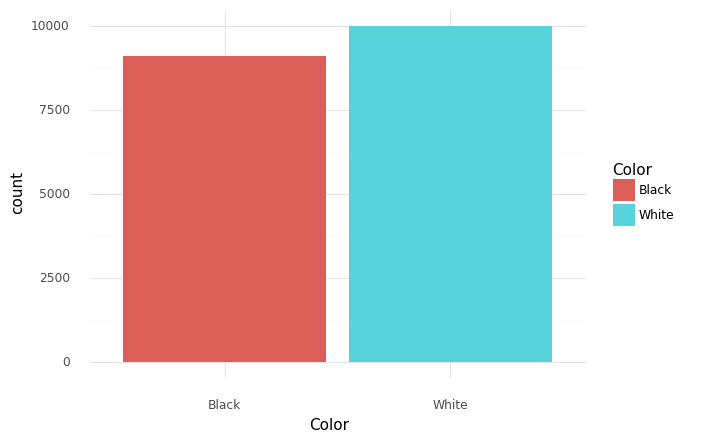

<ggplot: (123818903309)>

In [3]:
white=(db["winner"]=="white").sum()
black=(db["winner"]=="black").sum()
colorWinDb=pd.DataFrame({"Color": ["White", "Black"], 
                        "y":[white, black]})
(ggplot(colorWinDb, aes(x="Color", weight="y", fill="Color"))+geom_bar()+theme_minimal())

As expected there is no significant difference in wins whether the player was using the white pieces or black pieces. It also makes sense that there are slightly more wins for white since they start first. 

## Checking to see if rating makes a difference in predicting who is going to win 

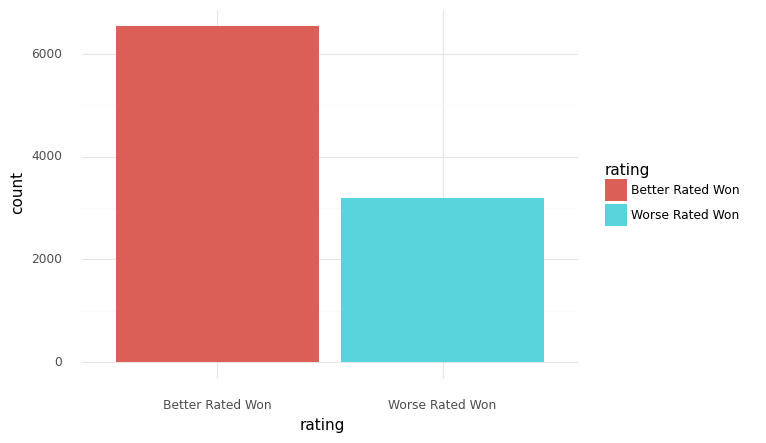

<ggplot: (123818922268)>

In [4]:
whiteBetter=0
blackBetter=0
whiteWorse=0
blackWorse=0
for index, row in db.iterrows():
    if((int(row["white_rating"])>int(row["black_rating"]) and row["winner"]=="white")):
        whiteBetter+=1
    elif(int(row["white_rating"])<int(row["black_rating"] and row["winner"]=="black")):
        blackBetter+=1
    elif(int(row["white_rating"])<int(row["black_rating"] and row["winner"]=="white")):
        whiteWorse+=1
    elif((int(row["white_rating"])>int(row["black_rating"]) and row["winner"]=="black")):
        blackWorse+=1
ratingWinDb=pd.DataFrame({"rating": ["Better Rated Won", "Worse Rated Won"], 
                        "y":[whiteBetter+blackBetter, blackWorse+whiteWorse]})
(ggplot(ratingWinDb, aes(x="rating", weight="y", fill="rating"))+geom_bar()+theme_minimal())



In [5]:
total=whiteBetter+blackBetter+blackWorse+whiteWorse
percent=float(((whiteBetter+blackBetter)/total)*100)
print(str(percent)+"% of better rated players won in their matchup vs a worse rated player")

67.18460588598477% of better rated players won in their matchup vs a worse rated player


This shows that a players rating is a big factor in determining whether a player will win in a matchup. The problem with this is that ratings don't carry over to playing on different sites or playing someone in real life. 

## Predicting who will win a game based off of the first couple moves

### Getting data ready

In [6]:
db["winner"] = db["winner"].astype('category')
db['winner_code']=db["winner"].cat.codes

db["opening_eco"]=db["opening_eco"].astype('category')
db["opening_eco_code"]=db["opening_eco"].cat.codes

db["opening_name"]=db["opening_name"].astype('category')
db["opening_name_code"]=db["opening_name"].cat.codes

db["victory_status"]=db["victory_status"].astype('category')
db["victory_status_code"]=db["victory_status"].cat.codes

db["increment_code"]=db["increment_code"].astype('category')
db["increment_code_num"]=db["increment_code"].cat.codes

In [7]:
db.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,...,black_rating,moves,opening_eco,opening_name,opening_ply,winner_code,opening_eco_code,opening_name_code,victory_status_code,increment_code_num
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,...,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,2,248,1387,2,110
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,...,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,0,71,750,3,298
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,...,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,2,171,650,1,298
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,...,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,2,241,992,1,187
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,...,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,2,192,783,1,247


In [8]:
predictors=["turns","opening_ply", "opening_eco_code", "opening_name_code", "victory_status_code", "increment_code_num" ]
#predictors=["turns", "opening_ply"]

In [9]:
x_train, x_test, y_train, y_test =train_test_split(db[predictors], db["winner_code"], test_size=.2)
#x_train= x_train.to_numpy()
#x_test = x_test.to_numpy()
#y_train = y_train.to_numpy()
#y_test = y_test.to_numpy()

len(x_train)

16046

In [10]:
x_val=x_train[:1500]
partial_x_train = x_train[1500:]
y_val=y_train[:1500]
partial_y_train = y_train[1500: ]

In [ ]:
clf = svm.SVC(kernel='linear')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)


### Building and testing model

In [40]:
model=models.Sequential()
model.add(layers.Dense(16, activation = 'relu', input_shape=(6,)))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(1, activation= 'sigmoid'))

In [41]:

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy']) 


In [42]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
results=model.evaluate(x_test, y_test)
results


Epoch 1/20
29/29 [==============================] - 1s 18ms/step - loss: 881.2703 - accuracy: 0.0646 - val_loss: 0.4495 - val_accuracy: 0.0527
Epoch 2/20
29/29 [==============================] - 0s 6ms/step - loss: -8.4145 - accuracy: 0.0465 - val_loss: 597.6501 - val_accuracy: 0.0527
Epoch 3/20
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.3407 - val_loss: nan - val_accuracy: 0.4700
Epoch 4/20
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4538 - val_loss: nan - val_accuracy: 0.4700
Epoch 5/20
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4538 - val_loss: nan - val_accuracy: 0.4700
Epoch 6/20
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4538 - val_loss: nan - val_accuracy: 0.4700
Epoch 7/20
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4538 - val_loss: nan - val_accuracy: 0.4700
Epoch 8/20
29/29 [==========================

[nan, 0.44890329241752625]

I can see the loss lowering each time but it also looks like it is just guessing the winner in this model, showing that the neural network is not very accurate. 

### Adding rating to model

In [47]:
predictors=["turns","opening_ply", "opening_eco_code", "opening_name_code", "victory_status_code", "increment_code_num", 
           "white_rating", "black_rating"]
x_train, x_test, y_train, y_test =train_test_split(db[predictors], db["winner_code"], test_size=.2)
x_train= x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
x_val=x_train[:1500]
partial_x_train = x_train[1500:]
y_val=y_train[:1500]
partial_y_train = y_train[1500: ]

In [48]:
model=models.Sequential()
model.add(layers.Dense(16, activation = 'relu', input_shape=(8,)))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(1, activation= 'sigmoid'))

In [49]:
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy']) 

In [50]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=2000,
                    batch_size=512,
                    validation_data=(x_val, y_val))
results=model.evaluate(x_test, y_test)
results


Epoch 1/2000
29/29 [==============================] - 1s 16ms/step - loss: nan - accuracy: 0.3543 - val_loss: nan - val_accuracy: 0.4480
Epoch 2/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 3/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 4/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 5/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 6/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 7/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 8/2000
29/29 [===========================

Epoch 61/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 62/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 63/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 64/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 65/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 66/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 67/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 68/2000
29/29 [====================

29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 180/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 181/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 182/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 183/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 184/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 185/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 186/2000
29/29 [===========================

29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 298/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 299/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 300/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 301/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 302/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 303/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 304/2000
29/29 [===========================

29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 416/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 417/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 418/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 419/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 420/2000
29/29 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 421/2000
29/29 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 422/2000
29/29 [===========================

29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 534/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 535/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 536/2000
29/29 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 537/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 538/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 539/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 540/2000
29/29 [===========================

29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 652/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 653/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 654/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 655/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 656/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 657/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 658/2000
29/29 [===========================

29/29 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 770/2000
29/29 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 771/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 772/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 773/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 774/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 775/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 776/2000
29/29 [===========================

29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 888/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 889/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 890/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 891/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 892/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 893/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 894/2000
29/29 [===========================

29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1006/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1007/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1008/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1009/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1010/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1011/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1012/2000
29/29 [====================

29/29 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1065/2000
29/29 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1066/2000
29/29 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1067/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1068/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1069/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1070/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1071/2000
29/29 [====================

29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1124/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1125/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1126/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1127/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1128/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1129/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1130/2000
29/29 [====================

Epoch 1182/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1183/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1184/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1185/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1186/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1187/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1188/2000
29/29 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1189/2000
29/29 [====

Epoch 1241/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1242/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1243/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1244/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1245/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1246/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1247/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1248/2000
29/29 [====

Epoch 1300/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1301/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1302/2000
29/29 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1303/2000
29/29 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1304/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1305/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1306/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1307/2000
29/29 [====

Epoch 1359/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1360/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1361/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1362/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1363/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1364/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1365/2000
29/29 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1366/2000
29/29 [====

Epoch 1476/2000
29/29 [==============================] - ETA: 0s - loss: nan - accuracy: 0.446 - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1477/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1478/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1479/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1480/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1481/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1482/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accu

29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1594/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1595/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1596/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1597/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1598/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1599/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1600/2000
29/29 [====================

29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1653/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1654/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1655/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1656/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1657/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1658/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1659/2000
29/29 [====================

29/29 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1712/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1713/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1714/2000
29/29 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1715/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1716/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1717/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1718/2000
29/29 [====================

Epoch 1770/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1771/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1772/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1773/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1774/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1775/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1776/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1777/2000
29/29 [====

Epoch 1829/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1830/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1831/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1832/2000
29/29 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1833/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1834/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1835/2000
29/29 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1836/2000
29/29 [====

29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1947/2000
29/29 [==============================] - ETA: 0s - loss: nan - accuracy: 0.454 - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1948/2000
29/29 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1949/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1950/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1951/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epoch 1952/2000
29/29 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.4545 - val_loss: nan - val_accuracy: 0.4480
Epo

[nan, 0.4546360969543457]

While the loss gets better with every epoch, the accuracy does not seem to be improving with the addition of rating